In [1]:
import random
import pandas as pd
import numpy as np
import os
import holidays

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from pycaret.regression import *
from pycaret import regression
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore') 
korea_holidays = holidays.SouthKorea(years=2023)
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [2]:
train = pd.read_csv('./open/train.csv')
print(train['사망자수'].value_counts())
print(train['중상자수'].value_counts())
print(train['경상자수'].value_counts())
print(train['부상자수'].value_counts())
print(len(train))
train['사고인원수'] = train['사망자수'] + train['중상자수'] + train['경상자수'] + train['부상자수']
train['ECLO'] -= 10*train['사망자수']
train['사고인원수'] -= train['사망자수']
train = train[(train['사고인원수'] < 6) & (train['사고인원수'] > 0)]
train['사고인원수'].value_counts()

0    39309
1      292
2        8
Name: 사망자수, dtype: int64
0    30136
1     8724
2      618
3       98
4       28
5        4
6        1
Name: 중상자수, dtype: int64
1     20913
0     10284
2      5560
3      1728
4       732
5       259
6        77
7        32
8         7
9         7
10        2
15        2
14        1
11        1
12        1
18        1
13        1
22        1
Name: 경상자수, dtype: int64
0     35168
1      4046
2       279
3        67
4        35
5         9
6         3
7         1
10        1
Name: 부상자수, dtype: int64
39609


1    27949
2     7365
3     2417
4      990
5      419
Name: 사고인원수, dtype: int64

In [21]:
# target = '경상자수'

def preprocess(target):
    light_df = pd.read_csv('./open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]
    location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
    light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
    light_df = light_df.drop(columns=['소재지지번주소', '번지'])
    light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
    light_df.reset_index(inplace=True, drop=True)

    child_area_df = pd.read_csv('./open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()# [['소재지지번주소']]
    child_area_df['시설수'] = 1
    location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
    child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
    child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
    child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
    child_area_df.reset_index(inplace=True, drop=True)

    parking_df = pd.read_csv('./open/external_open/대구 주차장 정보.csv', encoding='cp949')
    parking_df = pd.get_dummies(parking_df, columns=['급지구분'])
    location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
    parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
    parking_df = parking_df.drop(columns=['소재지지번주소', '번지','위도','경도'])
    parking_df = parking_df.groupby(['도시', '구', '동']).mean().reset_index()
    parking_df.reset_index(inplace=True, drop=True)
    parking_df = parking_df.fillna(0)

    train = pd.read_csv('./open/train.csv')
    test = pd.read_csv('./open/test.csv')
    train['사고인원수'] = train['사망자수'] + train['중상자수'] + train['경상자수'] + train['부상자수']
#     train = train[train['ECLO'] <= 30]
    train = train[train['사고인원수'] < 7]
    
    cols = list(test.columns)
    cols.append(target)
    train = train[cols]

    time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 
    train[['연', '월', '일', '시간']] = train['사고일시'].str.extract(time_pattern)
    train[['연', '월', '일', '시간']] = train[['연', '월', '일', '시간']].apply(pd.to_numeric) 
    train = train.drop(columns=['사고일시'])
    test[['연', '월', '일', '시간']] = test['사고일시'].str.extract(time_pattern)
    test[['연', '월', '일', '시간']] = test[['연', '월', '일', '시간']].apply(pd.to_numeric)
    test = test.drop(columns=['사고일시'])

    location_pattern = r'(\S+) (\S+) (\S+)'
    train[['도시', '구', '동']] = train['시군구'].str.extract(location_pattern)
    train = train.drop(columns=['시군구'])
    test[['도시', '구', '동']] = test['시군구'].str.extract(location_pattern)
    test = test.drop(columns=['시군구'])

    road_pattern = r'(.+) - (.+)'
    train[['도로형태1', '도로형태2']] = train['도로형태'].str.extract(road_pattern)
    train = train.drop(columns=['도로형태'])

    test[['도로형태1', '도로형태2']] = test['도로형태'].str.extract(road_pattern)
    test = test.drop(columns=['도로형태'])

    train = pd.merge(train, light_df, how='left', on=['도시', '구', '동'])
    train = pd.merge(train, child_area_df, how='left', on=['도시', '구', '동'])
    train = pd.merge(train, parking_df, how='left', on=['도시', '구', '동'])

    test = pd.merge(test, light_df, how='left', on=['도시', '구', '동'])
    test = pd.merge(test, child_area_df, how='left', on=['도시', '구', '동'])
    test = pd.merge(test, parking_df, how='left', on=['도시', '구', '동'])
    
    ohe = OneHotEncoder(sparse=False)
    train_gu_name = ohe.fit_transform(train[["구"]])
    train_gu_name = pd.DataFrame(train_gu_name, columns=[col for col in ohe.categories_[0]])
    train = pd.concat([train.drop(columns=['구']), train_gu_name], axis=1)
    test_gu_name = ohe.fit_transform(test[["구"]])
    test_gu_name = pd.DataFrame(test_gu_name, columns=[col for col in ohe.categories_[0]])
    test = pd.concat([test.drop(columns=['구']), test_gu_name], axis=1)
    
    ohe = OneHotEncoder(sparse=False)
    train_gu_name = ohe.fit_transform(train[["도시"]])
    train_gu_name = pd.DataFrame(train_gu_name, columns=[col for col in ohe.categories_[0]])
    train = pd.concat([train.drop(columns=['도시']), train_gu_name], axis=1)
    test_gu_name = ohe.fit_transform(test[["도시"]])
    test_gu_name = pd.DataFrame(test_gu_name, columns=[col for col in ohe.categories_[0]])
    test = pd.concat([test.drop(columns=['도시']), test_gu_name], axis=1)

    train = train.fillna(train.mean())
#     test = test.fillna(0)
    
    train = train.drop(['ID'],axis=1)
    test = test.drop(['ID'],axis=1)
        
#     train = train.drop(['ID'],axis=1)
#     test = test.drop(['ID'],axis=1)
    
    train = train.fillna(0)
    test = test.fillna(0)

#     train = train[train['ECLO'] <= 40]
    train = train.reset_index(drop=True)
    categorical_features = list(train.dtypes[train.dtypes == "object"].index)
    for i in categorical_features:
        le = LabelEncoder()
        train[i] = le.fit_transform(train[i])
        test[i] = le.transform(test[i])

    # train = train[train['ECLO'] <= 40]
    
    tp = train[target]
    train = train.drop(target,axis=1)
    train[target] = tp
    train = train.reset_index(drop=True)
            
    return train,test

In [22]:
def feature_selection(train,test,ratio):
    X_train, X_test, y_train, y_test = train_test_split(train.drop(target,axis=1), train[target], test_size=0.1, random_state=42)

    model = CatBoostRegressor(random_state=42,loss_function='MAE')
    model.fit(X_train, y_train)

    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    feature_importance = result.importances_mean

    tp = {i:feature_importance[i]/3 for i in range(len(feature_importance))}
    sorted_dict = dict(sorted(tp.items(), key=lambda item: item[1], reverse=True))

    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)

    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    feature_importance = result.importances_mean

    tp = {i:feature_importance[i] for i in range(len(feature_importance))}
    for i in tqdm(tp.keys()):
        sorted_dict[i] += tp[i]/3

    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)

    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    feature_importance = result.importances_mean

    tp = {i:feature_importance[i] for i in range(len(feature_importance))}
    for i in tqdm(tp.keys()):
        sorted_dict[i] += tp[i]/3
    # ratio = 0.8
    k = int(len(train.drop(target,axis=1).columns)*ratio)
    selected_features = list(sorted_dict.keys())[:k]
    train = train.iloc[:,selected_features]
    test = test.iloc[:,selected_features]
    return train, test

In [23]:
data = pd.DataFrame()
# for target in ('부상자수','경상자수','중상자수'):
target = 'ECLO'
train,test = preprocess(target)
#     X_train, X_test, y_train, y_test = train_test_split(train.drop(target,axis=1), train[target], test_size=0.1, random_state=42)

#     model = CatBoostRegressor(random_state=42)
#     model.fit(X_train, y_train)

#     result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
#     feature_importance = result.importances_mean

#     tp = {i:feature_importance[i] for i in range(len(feature_importance))}
#     sorted_dict = dict(sorted(tp.items(), key=lambda item: item[1], reverse=True))

#     ratio = 0.8
#     k = int(len(train.drop(target,axis=1).columns)*ratio)
#     selected_features = list(sorted_dict.keys())[:k]
#     test = test.iloc[:,selected_features]
ftrain,ftest = feature_selection(train,test,0.7)

setup(data=ftrain,target=train[target]
                     ,train_size=0.9
                     ,fold=10
                     ,fold_strategy='kfold'
                     ,data_split_shuffle=True
                     ,session_id=42
#                      ,outliers_threshold=0.01
                     ,verbose=200)
best = regression.compare_models(sort='RMSLE',n_select=5)
best_tune = [tune_model(i) for i in best]
tar = sum([i.predict(ftest) for i in best_tune])/len(best_tune)
data[target] = tar

0:	learn: 1.9338292	total: 15ms	remaining: 15s
1:	learn: 1.9338216	total: 29.4ms	remaining: 14.7s
2:	learn: 1.9337659	total: 45.4ms	remaining: 15.1s
3:	learn: 1.9333860	total: 59ms	remaining: 14.7s
4:	learn: 1.9333625	total: 74.3ms	remaining: 14.8s
5:	learn: 1.9330701	total: 88.5ms	remaining: 14.7s
6:	learn: 1.9328347	total: 104ms	remaining: 14.7s
7:	learn: 1.9325294	total: 119ms	remaining: 14.7s
8:	learn: 1.9322721	total: 129ms	remaining: 14.2s
9:	learn: 1.9319549	total: 141ms	remaining: 14s
10:	learn: 1.9315790	total: 154ms	remaining: 13.8s
11:	learn: 1.9313873	total: 166ms	remaining: 13.7s
12:	learn: 1.9311925	total: 178ms	remaining: 13.5s
13:	learn: 1.9306923	total: 186ms	remaining: 13.1s
14:	learn: 1.9303113	total: 193ms	remaining: 12.7s
15:	learn: 1.9299138	total: 200ms	remaining: 12.3s
16:	learn: 1.9296826	total: 206ms	remaining: 11.9s
17:	learn: 1.9292486	total: 212ms	remaining: 11.6s
18:	learn: 1.9289616	total: 220ms	remaining: 11.4s
19:	learn: 1.9285771	total: 227ms	remaining

178:	learn: 1.9052721	total: 1.7s	remaining: 7.8s
179:	learn: 1.9051993	total: 1.71s	remaining: 7.79s
180:	learn: 1.9051469	total: 1.72s	remaining: 7.76s
181:	learn: 1.9050932	total: 1.72s	remaining: 7.75s
182:	learn: 1.9049205	total: 1.73s	remaining: 7.73s
183:	learn: 1.9048473	total: 1.74s	remaining: 7.71s
184:	learn: 1.9047433	total: 1.75s	remaining: 7.69s
185:	learn: 1.9046493	total: 1.75s	remaining: 7.68s
186:	learn: 1.9045750	total: 1.76s	remaining: 7.67s
187:	learn: 1.9044907	total: 1.77s	remaining: 7.65s
188:	learn: 1.9044427	total: 1.78s	remaining: 7.64s
189:	learn: 1.9043337	total: 1.79s	remaining: 7.62s
190:	learn: 1.9042875	total: 1.8s	remaining: 7.61s
191:	learn: 1.9042135	total: 1.81s	remaining: 7.61s
192:	learn: 1.9041567	total: 1.82s	remaining: 7.6s
193:	learn: 1.9040977	total: 1.83s	remaining: 7.59s
194:	learn: 1.9040417	total: 1.84s	remaining: 7.58s
195:	learn: 1.9039211	total: 1.85s	remaining: 7.58s
196:	learn: 1.9038336	total: 1.86s	remaining: 7.57s
197:	learn: 1.90

349:	learn: 1.8957588	total: 3.36s	remaining: 6.25s
350:	learn: 1.8957357	total: 3.37s	remaining: 6.24s
351:	learn: 1.8957152	total: 3.38s	remaining: 6.23s
352:	learn: 1.8956867	total: 3.39s	remaining: 6.22s
353:	learn: 1.8956374	total: 3.4s	remaining: 6.21s
354:	learn: 1.8956051	total: 3.41s	remaining: 6.2s
355:	learn: 1.8955870	total: 3.42s	remaining: 6.19s
356:	learn: 1.8955719	total: 3.43s	remaining: 6.18s
357:	learn: 1.8955203	total: 3.44s	remaining: 6.17s
358:	learn: 1.8954836	total: 3.45s	remaining: 6.16s
359:	learn: 1.8954464	total: 3.46s	remaining: 6.15s
360:	learn: 1.8954095	total: 3.47s	remaining: 6.14s
361:	learn: 1.8953930	total: 3.48s	remaining: 6.13s
362:	learn: 1.8953607	total: 3.48s	remaining: 6.11s
363:	learn: 1.8953011	total: 3.49s	remaining: 6.1s
364:	learn: 1.8952790	total: 3.5s	remaining: 6.09s
365:	learn: 1.8952356	total: 3.51s	remaining: 6.08s
366:	learn: 1.8951997	total: 3.52s	remaining: 6.06s
367:	learn: 1.8951735	total: 3.52s	remaining: 6.05s
368:	learn: 1.89

524:	learn: 1.8877836	total: 4.83s	remaining: 4.37s
525:	learn: 1.8877431	total: 4.83s	remaining: 4.36s
526:	learn: 1.8877279	total: 4.84s	remaining: 4.34s
527:	learn: 1.8876947	total: 4.85s	remaining: 4.33s
528:	learn: 1.8876325	total: 4.86s	remaining: 4.33s
529:	learn: 1.8875486	total: 4.87s	remaining: 4.32s
530:	learn: 1.8875007	total: 4.88s	remaining: 4.31s
531:	learn: 1.8874293	total: 4.89s	remaining: 4.3s
532:	learn: 1.8873940	total: 4.9s	remaining: 4.29s
533:	learn: 1.8873532	total: 4.91s	remaining: 4.28s
534:	learn: 1.8872667	total: 4.92s	remaining: 4.28s
535:	learn: 1.8872066	total: 4.93s	remaining: 4.27s
536:	learn: 1.8871388	total: 4.94s	remaining: 4.26s
537:	learn: 1.8871011	total: 4.94s	remaining: 4.25s
538:	learn: 1.8870419	total: 4.95s	remaining: 4.24s
539:	learn: 1.8869735	total: 4.96s	remaining: 4.22s
540:	learn: 1.8869401	total: 4.97s	remaining: 4.21s
541:	learn: 1.8868962	total: 4.98s	remaining: 4.21s
542:	learn: 1.8868632	total: 4.99s	remaining: 4.2s
543:	learn: 1.8

702:	learn: 1.8806545	total: 6.51s	remaining: 2.75s
703:	learn: 1.8806246	total: 6.52s	remaining: 2.74s
704:	learn: 1.8806054	total: 6.52s	remaining: 2.73s
705:	learn: 1.8805937	total: 6.53s	remaining: 2.72s
706:	learn: 1.8805543	total: 6.54s	remaining: 2.71s
707:	learn: 1.8805370	total: 6.55s	remaining: 2.7s
708:	learn: 1.8805222	total: 6.57s	remaining: 2.69s
709:	learn: 1.8804941	total: 6.58s	remaining: 2.69s
710:	learn: 1.8804366	total: 6.59s	remaining: 2.68s
711:	learn: 1.8803984	total: 6.6s	remaining: 2.67s
712:	learn: 1.8803657	total: 6.61s	remaining: 2.66s
713:	learn: 1.8803324	total: 6.62s	remaining: 2.65s
714:	learn: 1.8803049	total: 6.63s	remaining: 2.64s
715:	learn: 1.8802943	total: 6.64s	remaining: 2.63s
716:	learn: 1.8802786	total: 6.65s	remaining: 2.62s
717:	learn: 1.8802664	total: 6.66s	remaining: 2.62s
718:	learn: 1.8802474	total: 6.67s	remaining: 2.61s
719:	learn: 1.8802167	total: 6.68s	remaining: 2.6s
720:	learn: 1.8801974	total: 6.69s	remaining: 2.59s
721:	learn: 1.8

867:	learn: 1.8758564	total: 7.96s	remaining: 1.21s
868:	learn: 1.8758352	total: 7.97s	remaining: 1.2s
869:	learn: 1.8758111	total: 7.97s	remaining: 1.19s
870:	learn: 1.8757344	total: 7.98s	remaining: 1.18s
871:	learn: 1.8756837	total: 7.98s	remaining: 1.17s
872:	learn: 1.8756439	total: 7.99s	remaining: 1.16s
873:	learn: 1.8756157	total: 8s	remaining: 1.15s
874:	learn: 1.8755719	total: 8s	remaining: 1.14s
875:	learn: 1.8754256	total: 8.01s	remaining: 1.13s
876:	learn: 1.8753939	total: 8.01s	remaining: 1.12s
877:	learn: 1.8753814	total: 8.02s	remaining: 1.11s
878:	learn: 1.8753241	total: 8.03s	remaining: 1.1s
879:	learn: 1.8753118	total: 8.03s	remaining: 1.09s
880:	learn: 1.8753031	total: 8.04s	remaining: 1.08s
881:	learn: 1.8751955	total: 8.04s	remaining: 1.08s
882:	learn: 1.8751168	total: 8.05s	remaining: 1.07s
883:	learn: 1.8750763	total: 8.06s	remaining: 1.06s
884:	learn: 1.8750113	total: 8.06s	remaining: 1.05s
885:	learn: 1.8749762	total: 8.07s	remaining: 1.04s
886:	learn: 1.874937

100%|██████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<?, ?it/s]


,Description,Value
0,Session id,42
1,Target,ECLO
2,Target type,Regression
3,Original data shape,"(39497, 24)"
4,Transformed data shape,"(39497, 24)"
5,Transformed train set shape,"(35547, 24)"
6,Transformed test set shape,"(3950, 24)"
7,Numeric features,23
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,2.0109,9.0828,3.0122,-0.0593,0.4453,0.5095,0.1250
gbr,Gradient Boosting Regressor,2.0683,8.3015,2.8799,0.0316,0.4493,0.6122,0.8880
lightgbm,Light Gradient Boosting Machine,2.0797,8.3667,2.8913,0.0239,0.4513,0.6145,0.1170
br,Bayesian Ridge,2.0891,8.4573,2.9068,0.0135,0.4540,0.6223,0.0400
lr,Linear Regression,2.0894,8.4573,2.9068,0.0135,0.4540,0.6223,0.5830
ridge,Ridge Regression,2.0895,8.4578,2.9069,0.0134,0.4541,0.6224,0.0320
catboost,CatBoost Regressor,2.0950,8.5098,2.9160,0.0071,0.4559,0.6176,2.2390
en,Elastic Net,2.0960,8.5691,2.9259,0.0005,0.4563,0.6229,0.0360
llar,Lasso Least Angle Regression,2.0966,8.5735,2.9266,-0.0000,0.4564,0.6232,0.0360
omp,Orthogonal Matching Pursuit,2.0963,8.5737,2.9267,-0.0001,0.4564,0.6230,0.0360


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.0192,8.7494,2.9579,-0.0284,0.4443,0.5433
1,2.0834,9.8907,3.1449,-0.0386,0.4524,0.5381
2,2.0320,8.8852,2.9808,-0.0352,0.4502,0.5498
3,1.9994,8.9209,2.9868,-0.0365,0.4366,0.5130
4,2.0569,8.9217,2.9869,-0.0344,0.4524,0.5537
5,1.9687,7.9185,2.8140,-0.0368,0.4324,0.5199
6,2.0356,8.8051,2.9673,-0.0370,0.4447,0.5338
7,1.9778,8.2714,2.8760,-0.0277,0.4383,0.5357
8,2.0039,8.5902,2.9309,-0.0341,0.4414,0.5356


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.0689,8.2012,2.8638,0.0360,0.4510,0.6234
1,2.1201,9.1858,3.0308,0.0355,0.4550,0.6129
2,2.0757,8.3147,2.8835,0.0312,0.4533,0.6253
3,2.0469,8.4569,2.9081,0.0175,0.4441,0.5892
4,2.1103,8.3926,2.8970,0.0270,0.4588,0.6347
5,1.9974,7.4391,2.7275,0.0259,0.4375,0.5906
6,2.0863,8.2654,2.8750,0.0266,0.4517,0.6162
7,2.0238,7.7959,2.7921,0.0314,0.4461,0.6153
8,2.0370,8.0169,2.8314,0.0349,0.4469,0.6131


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.0742,8.2130,2.8658,0.0346,0.4517,0.6270
1,2.1219,9.1903,3.0316,0.0350,0.4552,0.6157
2,2.0751,8.2812,2.8777,0.0351,0.4524,0.6248
3,2.0473,8.4233,2.9023,0.0214,0.4434,0.5905
4,2.1091,8.3803,2.8949,0.0284,0.4586,0.6359
5,2.0017,7.4214,2.7242,0.0283,0.4376,0.5930
6,2.0905,8.2777,2.8771,0.0251,0.4517,0.6172
7,2.0226,7.7665,2.7868,0.0351,0.4454,0.6150
8,2.0333,8.0046,2.8292,0.0364,0.4462,0.6116


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.0983,8.4164,2.9011,0.0107,0.4578,0.6387
1,2.1366,9.3622,3.0598,0.0169,0.4601,0.6251
2,2.0921,8.4612,2.9088,0.0141,0.4570,0.6327
3,2.0563,8.5108,2.9173,0.0112,0.4458,0.5956
4,2.1327,8.5399,2.9223,0.0099,0.4635,0.6466
5,2.0137,7.5295,2.7440,0.0141,0.4412,0.6004
6,2.1017,8.3871,2.8961,0.0122,0.4546,0.6230
7,2.0461,7.9380,2.8174,0.0138,0.4505,0.6251
8,2.0532,8.1689,2.8581,0.0166,0.4507,0.6206


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.0985,8.4204,2.9018,0.0103,0.4579,0.6388
1,2.1369,9.3634,3.0600,0.0168,0.4601,0.6250
2,2.0922,8.4588,2.9084,0.0144,0.4570,0.6325
3,2.0572,8.5129,2.9177,0.0110,0.4460,0.5960
4,2.1327,8.5353,2.9215,0.0105,0.4634,0.6466
5,2.0145,7.5322,2.7445,0.0137,0.4413,0.6006
6,2.1024,8.3878,2.8962,0.0121,0.4547,0.6232
7,2.0457,7.9369,2.8173,0.0139,0.4505,0.6248
8,2.0526,8.1680,2.8580,0.0167,0.4507,0.6203


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


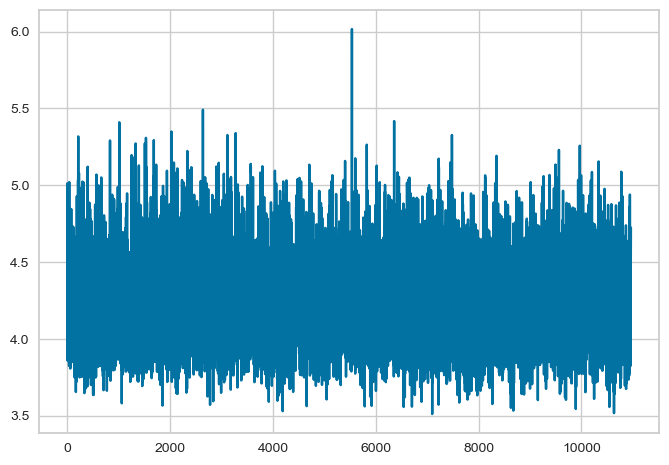

In [27]:
# data['ECLO'] = 5*data['중상자수']+3*data['경상자수'] + 1*data['부상자수']
plt.plot(data['ECLO'])

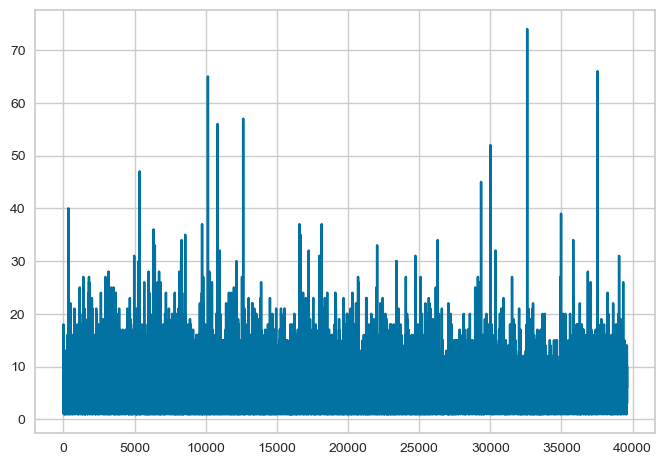

In [7]:
plt.plot(pd.read_csv('./open/train.csv')['ECLO'])

In [25]:
best_tune

[HuberRegressor(epsilon=1.9, fit_intercept=False),
 GradientBoostingRegressor(random_state=42),
 LGBMRegressor(bagging_fraction=0.6, bagging_freq=5, feature_fraction=1.0,
               min_child_samples=71, min_split_gain=0.6, n_estimators=130,
               num_leaves=4, random_state=42, reg_alpha=0.3, reg_lambda=4),
 BayesianRidge(),
 LinearRegression(n_jobs=-1)]

In [26]:
data['ECLO'] = 0.4*best_tune[0].predict(ftest) + 0.3*best_tune[1].predict(ftest) + 0.3*best_tune[2].predict(ftest)

In [28]:
sample_submission = pd.read_csv('./open/sample_submission.csv')
sample_submission["ECLO"] = data['ECLO']
sample_submission.to_csv("ohe-five-ratio0.7.csv", index=False)